## Get Data

In [1]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import math
import matplotlib.pyplot as plt
import os
import sys


ScaleTo = 70 # resizing to 80x80 for a quicker training of model
seed = 10 # fix the random

path = 'Data/*/*.png' 
files = glob(path)

trainImg = []
trainLabel = []
j =1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

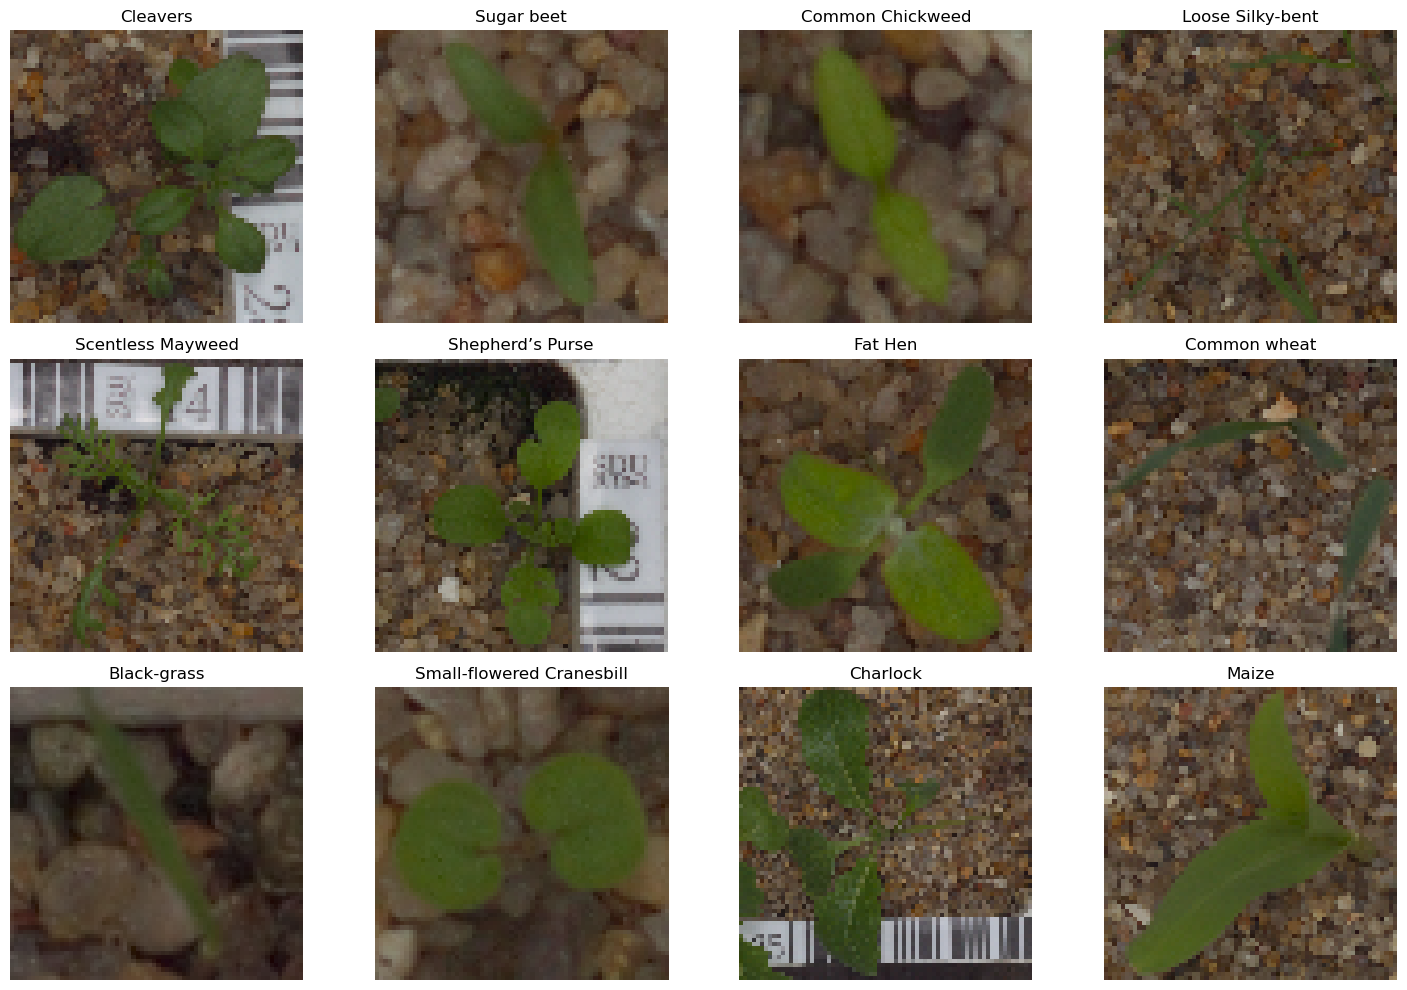

In [2]:
# Assuming you have already loaded your data into trainImg and trainLabel

# Create a dictionary to store one image per class
class_to_image = {}

# Iterate through the data and store one image for each class
for i in range(len(trainImg)):
    img = trainImg[i]
    label = trainLabel.iloc[i, 0]
    
    # Check if we have already stored an image for this class
    if label not in class_to_image:
        class_to_image[label] = img

# Plot one image per class with its label
plt.figure(figsize=(15, 10))
for i, (label, img) in enumerate(class_to_image.items()):
    plt.subplot(3, 4, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

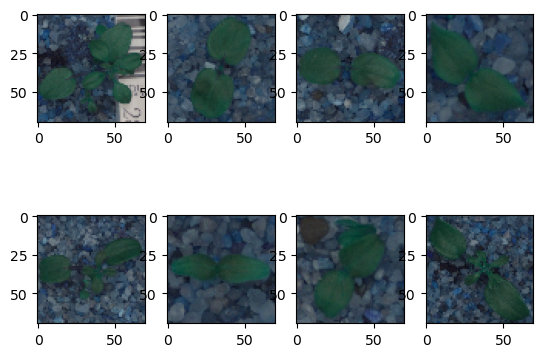

In [83]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

## Clean Data

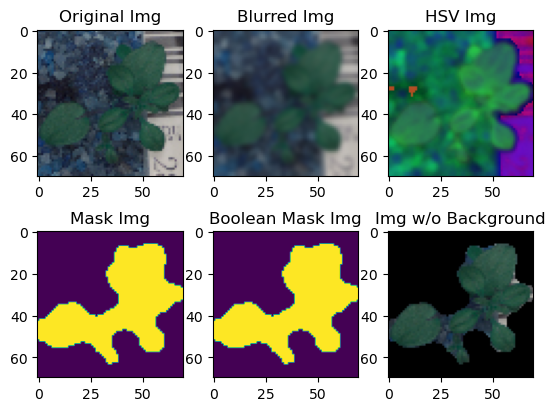

In [5]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5,5), 0)
    
    # Convert to HSV Image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8) # Create empty image
    clear[bMask] = img[bMask] # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1)
        plt.imshow(img)
        plt.title('Original Img')  # Label for the original image
        plt.subplot(2, 3, 2)
        plt.imshow(blurImg)
        plt.title('Blurred Img')  # Label for the blurred image
        plt.subplot(2, 3, 3)
        plt.imshow(hsvImg)
        plt.title('HSV Img')  # Label for the HSV image
        plt.subplot(2, 3, 4)
        plt.imshow(mask)
        plt.title('Mask Img')  # Label for the mask image
        plt.subplot(2, 3, 5)
        plt.imshow(bMask)
        plt.title('Boolean Mask Img')  # Label for the boolean mask image
        plt.subplot(2, 3, 6)
        plt.imshow(clear)
        plt.title('Img w/o Background')  # Label for the image without background
        getEx = False
#         plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
#         plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
#         plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
#         plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
#         plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
#         plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
#         getEx = False

clearTrainImg = np.asarray(clearTrainImg)

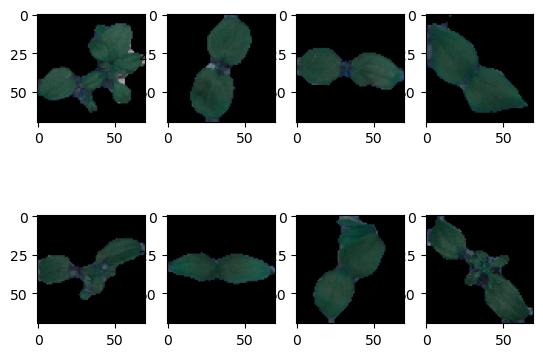

In [85]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

## Normalise input

In [86]:
clearTrainImg = clearTrainImg / 255

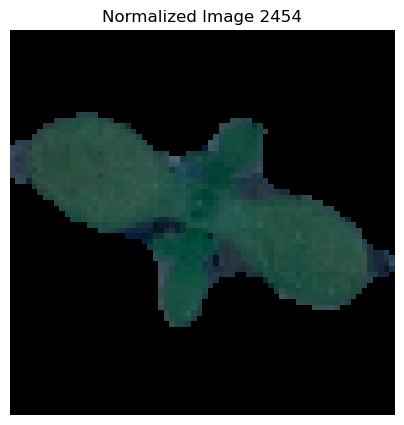

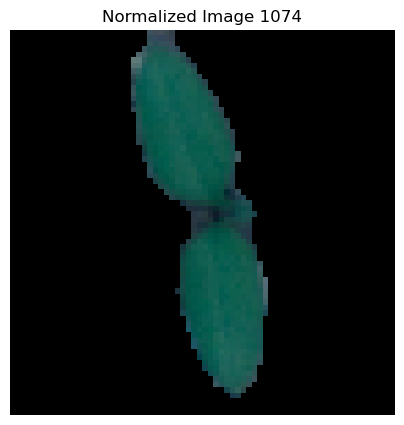

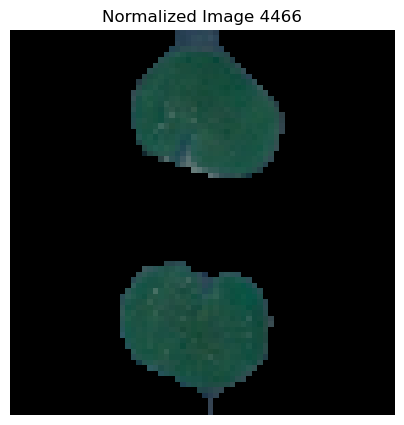

In [6]:
# Print a few normalized images
num_images_to_display = 3  # You can adjust this number as needed

for i in range(num_images_to_display):
    plt.figure(figsize=(5, 5))
    random_index = np.random.randint(0, len(clearTrainImg))
    image = clearTrainImg[random_index]
    plt.imshow(image)
    plt.title(f"Normalized Image {random_index}")
    plt.axis('off')
    plt.show()

## Categorise Labels

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherd’s Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


<Axes: >

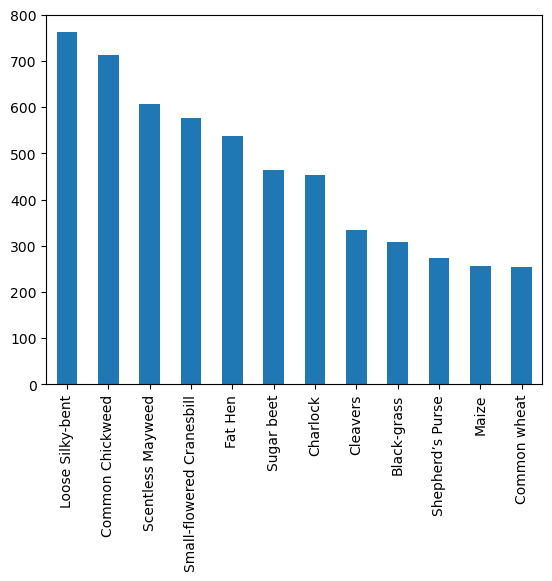

In [87]:
from sklearn import preprocessing

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])

# Make labels categorical
clearTrainLabel = np.zeros((len(encodeTrainLabels), len(np.unique(encodeTrainLabels))))
clearTrainLabel[np.arange(len(encodeTrainLabels)), encodeTrainLabels] = 1
num_classes = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_classes))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar')

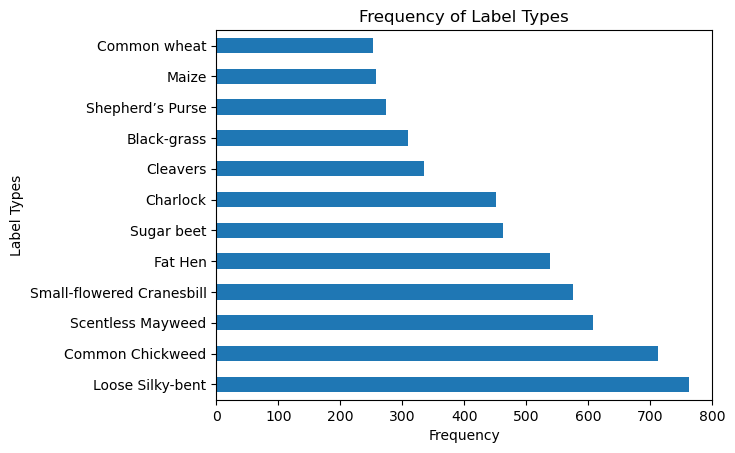

In [8]:
# Swap x and y for label type plot
trainLabel[0].value_counts().plot(kind='barh')  # Use 'barh' for horizontal bar plot
plt.xlabel('Frequency')  # Label for the x-axis
plt.ylabel('Label Types')  # Label for the y-axis
plt.title('Frequency of Label Types')
plt.show()

## Split Dataset

In [88]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and temporary validation (20%)
trainX, valX, trainY, valY = train_test_split(clearTrainImg, clearTrainLabel, 
                                              test_size=0.2, random_state=seed, 
                                              stratify=clearTrainLabel)

# Further split the temporary validation set into validation (10%) and test (10%)
valX, testX, valY, testY = train_test_split(valX, valY, 
                                            test_size=0.5, random_state=seed, 
                                            stratify=valY)

# Save the data to an NPZ file
np.savez("data.npz", trainX=trainX, valX=valX, testX=testX, trainY=trainY, valY=valY, testY=testY)

print(len(trainX))
print(len(trainY))
print(len(testY))
print(len(testX))
print(len(valX))
print(len(valY))

4431
4431
554
554
554
554


## Data Generator

In [89]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

## Create Model

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

np.random.seed(seed)  # Fix seed

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 66, 66, 64)        4864      
                                                                 
 batch_normalization_40 (Ba  (None, 66, 66, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_31 (Conv2D)          (None, 62, 62, 64)        102464    
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 31, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_41 (Ba  (None, 31, 31, 64)        256       
 tchNormalization)                                               
                                                      

## Fit Model

In [91]:
trainX.shape[0]

4431

In [92]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# checkpoints
filepath="Models/weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
filepath="Models/weights.last_auto4.hdf5"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=False, mode='max')

# all callbacks
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]

# fit model
hist = model.fit(datagen.flow(trainX, trainY, batch_size=75), 
                           epochs=35, validation_data=(testX, testY), 
                           steps_per_epoch=trainX.shape[0]//75, callbacks=callbacks_list)

Epoch 1/35
59/59 [==============================] - ETA: 0s - loss: 2.5116 - accuracy: 0.2831
Epoch 1: val_accuracy improved from -inf to 0.04693, saving model to Models/weights.best_01-0.05.hdf5

Epoch 1: saving model to Models/weights.last_auto4.hdf5
59/59 [==============================] - 84s 1s/step - loss: 2.5116 - accuracy: 0.2831 - val_loss: 12.5979 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 2/35


/Users/joachim/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


59/59 [==============================] - ETA: 0s - loss: 1.9189 - accuracy: 0.3981
Epoch 2: val_accuracy did not improve from 0.04693

Epoch 2: saving model to Models/weights.last_auto4.hdf5
59/59 [==============================] - 90s 2s/step - loss: 1.9189 - accuracy: 0.3981 - val_loss: 15.5283 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 3/35
59/59 [==============================] - ETA: 0s - loss: 1.6588 - accuracy: 0.4380
Epoch 3: val_accuracy did not improve from 0.04693

Epoch 3: saving model to Models/weights.last_auto4.hdf5
59/59 [==============================] - 111s 2s/step - loss: 1.6588 - accuracy: 0.4380 - val_loss: 13.6399 - val_accuracy: 0.0469 - lr: 0.0010
Epoch 4/35
59/59 [==============================] - ETA: 0s - loss: 1.4994 - accuracy: 0.4894
Epoch 4: val_accuracy improved from 0.04693 to 0.13899, saving model to Models/weights.best_04-0.14.hdf5

Epoch 4: saving model to Models/weights.last_auto4.hdf5
59/59 [==============================] - 108s 2s/step - loss: 1.

Epoch 24/35
59/59 [==============================] - ETA: 0s - loss: 0.5076 - accuracy: 0.8255
Epoch 24: val_accuracy improved from 0.84296 to 0.85199, saving model to Models/weights.best_24-0.85.hdf5

Epoch 24: saving model to Models/weights.last_auto4.hdf5
59/59 [==============================] - 114s 2s/step - loss: 0.5076 - accuracy: 0.8255 - val_loss: 0.4221 - val_accuracy: 0.8520 - lr: 1.6000e-04
Epoch 25/35
59/59 [==============================] - ETA: 0s - loss: 0.5043 - accuracy: 0.8239
Epoch 25: val_accuracy did not improve from 0.85199

Epoch 25: saving model to Models/weights.last_auto4.hdf5
59/59 [==============================] - 123s 2s/step - loss: 0.5043 - accuracy: 0.8239 - val_loss: 0.4970 - val_accuracy: 0.8339 - lr: 1.6000e-04
Epoch 26/35
59/59 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.8166
Epoch 26: val_accuracy did not improve from 0.85199

Epoch 26: saving model to Models/weights.last_auto4.hdf5
59/59 [==============================

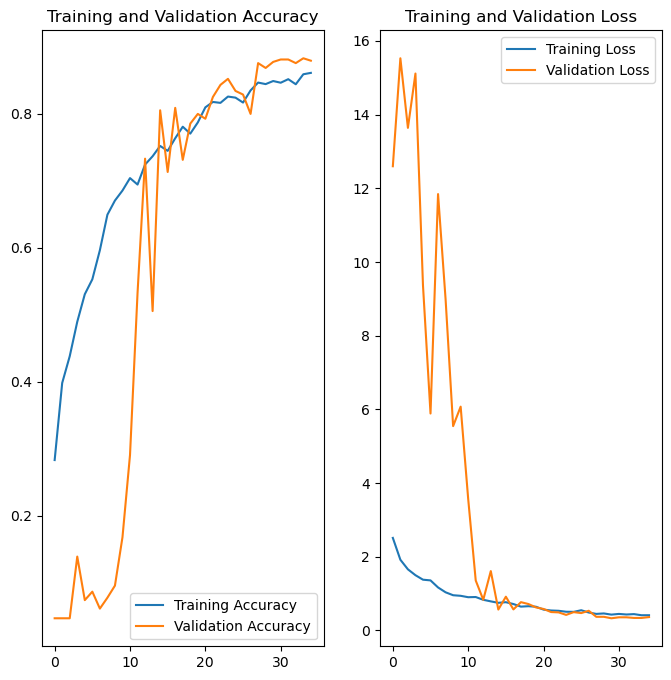

In [119]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Change the epochs_range variable to be the actual number of epochs that were run
epochs_range = range(len(hist.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [120]:
model.load_weights("Models/weights.best_34-0.88.hdf5")

data = np.load("data.npz")

d = dict(zip(("trainX","testX","valX","trainY", "testY", "valY"), (data[k] for k in data)))
trainX = d['trainX']
testX = d['testX']
valX = d['valX']
trainY = d['trainY']
testY = d['testY']
valY = d['valY']

print(model.evaluate(trainX, trainY))  # Evaluate on train set
print(model.evaluate(testX, testY))  # Evaluate on test set
print(model.evaluate(valX,valY)) # Evaluate on val set

139/139 [==============================] - 21s 150ms/step - loss: 0.2692 - accuracy: 0.9021
[0.26917335391044617, 0.902053713798523]
18/18 [==============================] - 3s 148ms/step - loss: 0.3359 - accuracy: 0.8827
[0.3358742892742157, 0.8826714754104614]
18/18 [==============================] - 3s 149ms/step - loss: 0.3393 - accuracy: 0.8827
[0.3392665386199951, 0.8826714754104614]


18/18 [==============================] - 3s 144ms/step


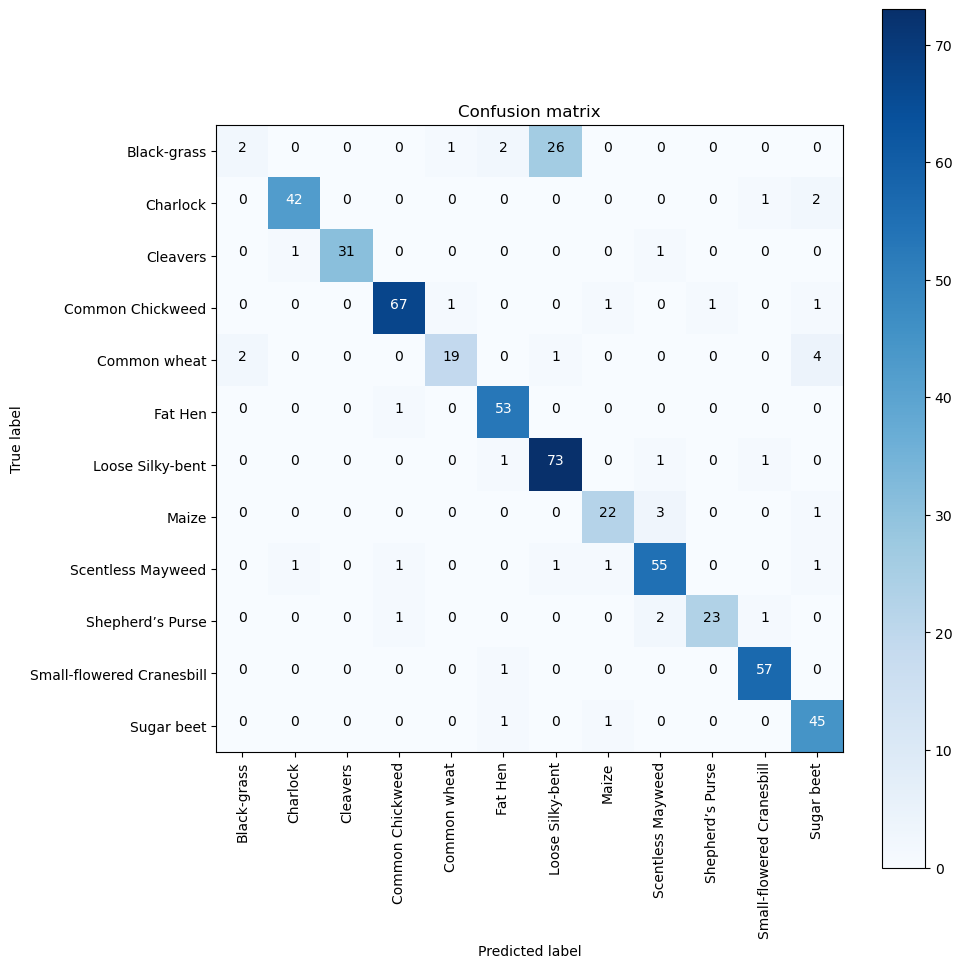

In [103]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(valX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(valY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

In [109]:
from sklearn.metrics import classification_report
class_report = classification_report(trueY, predYClasses, target_names=le.classes_)
print(class_report)

                           precision    recall  f1-score   support

              Black-grass       0.50      0.06      0.11        31
                 Charlock       0.95      0.93      0.94        45
                 Cleavers       1.00      0.94      0.97        33
         Common Chickweed       0.96      0.94      0.95        71
             Common wheat       0.90      0.73      0.81        26
                  Fat Hen       0.91      0.98      0.95        54
         Loose Silky-bent       0.72      0.96      0.82        76
                    Maize       0.88      0.85      0.86        26
        Scentless Mayweed       0.89      0.92      0.90        60
         Shepherd’s Purse       0.96      0.85      0.90        27
Small-flowered Cranesbill       0.95      0.98      0.97        58
               Sugar beet       0.83      0.96      0.89        47

                 accuracy                           0.88       554
                macro avg       0.87      0.84      0.84    